# Table of Contents
 <p><div class="lev1 toc-item"><a href="#AfSIS-Soil-Chemistry-Dataset-Usage-Tutorial" data-toc-modified-id="AfSIS-Soil-Chemistry-Dataset-Usage-Tutorial-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AfSIS Soil Chemistry Dataset Usage Tutorial</a></div><div class="lev2 toc-item"><a href="#Prerequisities" data-toc-modified-id="Prerequisities-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Prerequisities</a></div><div class="lev2 toc-item"><a href="#Downloading-the-Soil-Chemistry-Dataset-from-AWS" data-toc-modified-id="Downloading-the-Soil-Chemistry-Dataset-from-AWS-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Downloading the Soil Chemistry Dataset from AWS</a></div><div class="lev2 toc-item"><a href="#Loading-OPUS-spectra" data-toc-modified-id="Loading-OPUS-spectra-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Loading OPUS spectra</a></div><div class="lev2 toc-item"><a href="#3.-Adding-geographical-references" data-toc-modified-id="3.-Adding-geographical-references-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>3. Adding geographical references</a></div><div class="lev2 toc-item"><a href="#4.-Wet-chemistry" data-toc-modified-id="4.-Wet-chemistry-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>4. Wet chemistry</a></div><div class="lev2 toc-item"><a href="#Modelling" data-toc-modified-id="Modelling-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Modelling</a></div>

# AfSIS Soil Chemistry Dataset Usage Tutorial
--

This tutorial illustrates the kind of data included in the AfSIS Soil Chemistry Dataset hosted at the Registry of Open Data on AWS, and how it can be used in simple descriptive analyses and machine learning models.

## Prerequisities

In this tutorial, we require python3.6 with the following packages installed: 

* To download data:
    * aws-cli
* To parse and manage datasets:
    * brukeropusreader
    * pandas 
    * tqdm
* To make plots:
    * matplotlib
    * folium
    * seaborn
* To train machine learning models:
    * xgboost
    * scikit-learn

You can install all of this packages with one command:

    ! pip install awscli brukeropusreader tqdm pandas matplotlib folium seaborn scikit-learn xgboost           

##  Downloading the Soil Chemistry Dataset from AWS

Download s3 bucket content with the `aws-cli` command line tool. Run `aws configure` beforehand to set your credentials.

In [3]:
! aws s3 cp s3://dataset_path AfSIS_Phase_I --recursive

fatal error: An error occurred (NoSuchBucket) when calling the ListObjectsV2 operation: The specified bucket does not exist


## Loading OPUS spectra

OPUS spectra can be opened with the [brukeropusreader](https://github.com/qedsoftware/brukeropusreader) package. 

The function `read_file` parses the binaries and returns a data structure containing information about the wave numbers, absorbance spectra, and file metadata. In this tutorial, we will use spectra from the directory named `Bruker_MPA`.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from brukeropusreader import read_file
from tqdm import tqdm_notebook as tqdm

aws_path = Path('AfSIS_Phase_I/')

names = []
spectra = []
wave_nums = None

for file in tqdm(aws_path.glob('Bruker_MPA/*')):
    try:
        spect_data = read_file(file)
        spectra.append(spect_data.spectrum)
        names.append(file.name[:-2])
        wave_nums = spect_data.wave_nums
    except Exception:
        pass
    
column_names = ['{:.3f}'.format(x) for x in wave_nums]
spectra_df = pd.DataFrame(spectra, index=names, columns=column_names)

Here we plot a few of the spectra. 

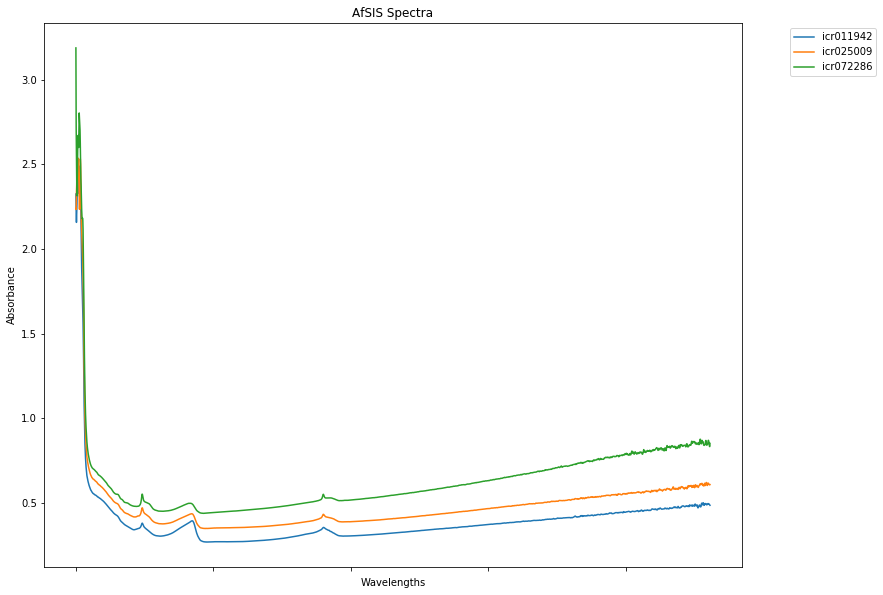

In [11]:
fig = spectra_df.sample(3).T.plot(figsize=(12.5, 10), title='AfSIS Spectra')
fig.set_xlabel("Wavelengths")
fig.set_ylabel("Absorbance")
fig.legend(bbox_to_anchor=(1.2, 1))

## 3. Adding geographical references

The AfSIS Soil Chemistry Dataset contains georeferences for each spectra. 
You can use them to locate every measurement on a map.

In [12]:
GEOREFS_FILE = 'AfSIS_Phase_I/Georeferences/georeferences.csv'
georefs_df = pd.read_csv(GEOREFS_FILE)

In [13]:
import folium
m = folium.Map(location=[-3.5, 35.6], tiles="stamentoner", zoom_start=3)
 
for _, row in georefs_df.iterrows():
    if row[['Latitude', 'Longitude']].notnull().all():
        folium.Marker([row['Latitude'], 
                       row['Longitude']], 
                      popup=row['SSN']
                     ).add_to(m)

m

You can also count the number of samples in each country:

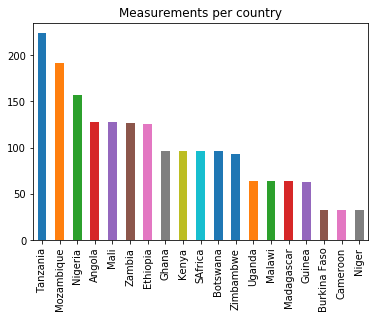

In [14]:
pd.value_counts(georefs_df['Country']).plot.bar(title='Measurements per country')

The georeferences table also contains many other pieces of metadata, as shown below:

In [15]:
georefs_df.head()

,SSN,Public,Latitude,Longitude,Cluster,Plot,Depth,Soil material,Scientist,Site,Country,Region,Cultivated,Gid
0,icr025136,True,-6.851620,34.243313,16,7,sub,NaN,Tor Vagen,Itende,Tanzania,East Africa,False,599
1,icr068579,True,11.280658,8.166768,9,1,top,Pamp.9.1.Topsoil.Std fine soil,Jerome Tondoh,Pampaida,Nigeria,West Africa,NaN,1487
2,icr048978,True,-29.972100,22.710200,1,1,sub,Prie.1.1.Subsoil.Std fine soil,George Van Zijl,Prieska,SAfrica,South Africa,False,786
3,icr056481,True,-16.066365,28.326498,15,1,sub,Mong.15.1.Subsoil.Std fine soil,L.T.Desta,Monga,Zambia,South Africa,True,1065
4,icr034190,True,8.158693,9.930640,15,1,top,Ibi.15.1.Topsoil.Std fine soil,Jerome Tondoh,Ibi,Nigeria,West Africa,True,655


## 4. Wet chemistry

The AfSIS Soil Chemistry dataset contains wet chemistry data taken at each sampling location.

In [16]:
WET_CHEM_PATH = 'AfSIS_Phase_I/TXRF/TXRF.csv'
columns_to_load = ['Ca', 'Na', 'K', 'Al', 'SSN']
elements = ['Ca', 'K', 'Al']

wet_chem_df = pd.read_csv(WET_CHEM_PATH, index_col='SSN', usecols=columns_to_load)

You can plot the elemental distributions of all loaded samples using the `seaborn` library. 

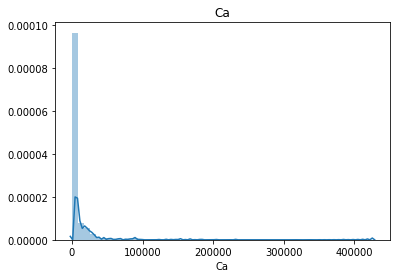

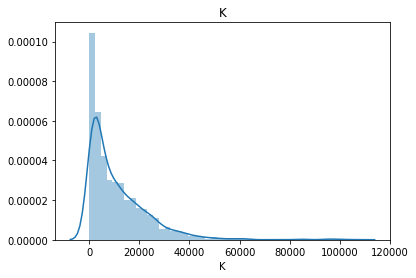

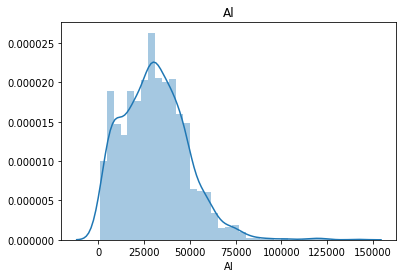

In [17]:
import seaborn as sn

for e in elements:
  sn.distplot(wet_chem_df[e]).set_title(e)
  plt.show()    

We can also check for correlations between any of the wet chemistry pairs. 

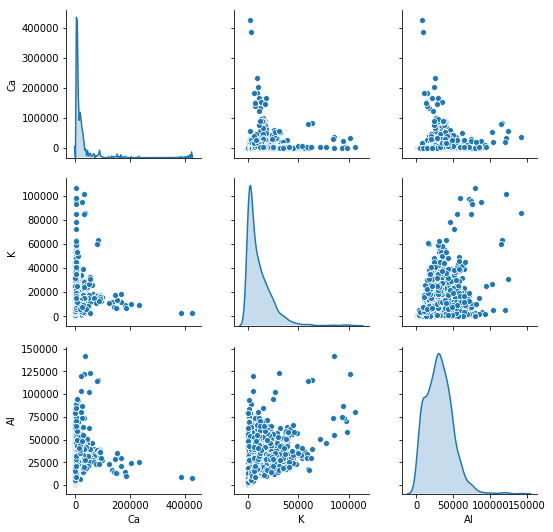

In [18]:
sn.pairplot(wet_chem_df[elements], diag_kind='kde')

## Modelling

Together, the wet chemistry and dry chemistry measurements can serve as a training dataset for performing spectral inference.
Namely, we can prepare algorithmic data models to estimate the elemental concentrations that wet chemistry would have produced, based on spectral measurements. Below is a very simple example of how this can work. 

In [20]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

import numpy as np
from xgboost import XGBRegressor

data_df = spectra_df.merge(wet_chem_df, left_index=True, right_index=True)
print(f'Training model for Ca...')

x = data_df[column_names]
x = np.apply_along_axis(np.gradient, 1, x)
y = np.log1p(data_df['Ca'])
    
kfold = KFold(shuffle=True, random_state=0, n_splits=4)
model = XGBRegressor(n_estimators=500, n_jobs=-1)
    
print('Cross validation r^2 accuracies:', cross_validate(model, x, y, scoring='r2', cv=kfold)['test_score'])

Training model for Ca...
Cross validation r^2 accuracies: [0.81103318 0.81416482 0.80581501 0.82581904]
